# 02. Window Memory + Tool Calling 통합 학습

이 노트북에서는 **Window Memory** 방식과 **Tool Calling**을 LangGraph + SQLiteSaver로 통합 구현합니다.

## 학습 목표
- Window Memory의 개념과 Buffer Memory와의 차이점 이해
- 최근 N개 메시지만 유지하는 방법 (RemoveMessage 활용)
- SQLiteSaver를 사용한 영구 메모리 저장
- 커스텀 도구 + 공식 도구 통합

---

## Buffer Memory vs Window Memory 비교

| 구분 | Buffer Memory | Window Memory |
|------|---------------|---------------|
| **저장 방식** | 모든 메시지 누적 | 최근 K개만 유지 |
| **토큰 비용** | 대화 길이에 비례 증가 | 일정하게 유지 |
| **장점** | 전체 맥락 보존 | 비용 효율적 |
| **단점** | 비용 증가, 컨텍스트 초과 위험 | 오래된 정보 손실 |
| **적합한 상황** | 짧은 대화, 맥락이 중요한 작업 | 긴 대화, 비용 관리 필요 시 |



---

## 1. 패키지 설치

In [1]:
!pip install langchain langchain-anthropic langgraph langgraph-checkpoint-sqlite -q
!pip install langchain-community wikipedia duckduckgo-search ddgs -q
print("설치 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


---

## 2. 모델 선택

In [2]:
# ===== Claude 4.5 모델 선택 =====

# 1. Haiku 4.5 - 가장 빠르고 저렴 (테스트용 추천)
MODEL = "claude-haiku-4-5-20251001"

# 2. Sonnet 4.5 - 균형 잡힌 성능
# MODEL = "claude-sonnet-4-5-20250929"

# 3. Opus 4.5 - 최고 성능
# MODEL = "claude-opus-4-5-20251101"

print(f"선택된 모델: {MODEL}")

선택된 모델: claude-haiku-4-5-20251001


---

## 3. API 키 설정

In [3]:

import os

# 방법 1: 직접 입력
# os.environ["ANTHROPIC_API_KEY"] = "sk-ant-여기에-API-키-입력"

# 방법 2: Colab Secrets (권장)
try:
    from google.colab import userdata
    os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")
    print("Colab Secrets에서 API 키를 불러왔습니다!")
except:
    if "ANTHROPIC_API_KEY" in os.environ:
        print("환경 변수에서 API 키를 찾았습니다!")
    else:
        print("API 키를 직접 입력해주세요.")

Colab Secrets에서 API 키를 불러왔습니다!


---

## 4. LLM 및 기본 구성요소 초기화

In [5]:
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage, RemoveMessage

# LLM 초기화
llm = ChatAnthropic(
    model=MODEL,
    max_tokens=1024
)

print("LLM 초기화 완료!")

LLM 초기화 완료!


---

## 5. 커스텀 도구 정의

In [6]:
from langchain_core.tools import tool
from datetime import datetime
import random

@tool
def get_current_time() -> str:
    """현재 날짜와 시간을 조회합니다. 사용자가 시간이나 날짜를 물어볼 때 사용하세요."""
    now = datetime.now()
    return f"현재 시간: {now.strftime('%Y년 %m월 %d일 %H시 %M분')}"

@tool
def calculator(a: float, b: float, operation: str) -> str:
    """두 숫자의 사칙연산을 수행합니다.

    Args:
        a: 첫 번째 숫자
        b: 두 번째 숫자
        operation: 수행할 연산 (add, subtract, multiply, divide)
    """
    operations = {
        "add": lambda x, y: x + y,
        "subtract": lambda x, y: x - y,
        "multiply": lambda x, y: x * y,
        "divide": lambda x, y: x / y if y != 0 else "오류: 0으로 나눌 수 없습니다"
    }

    if operation not in operations:
        return f"지원하지 않는 연산: {operation}"

    result = operations[operation](a, b)
    op_symbols = {"add": "+", "subtract": "-", "multiply": "×", "divide": "÷"}
    return f"{a} {op_symbols[operation]} {b} = {result}"

@tool
def random_number(min_val: int, max_val: int) -> str:
    """지정된 범위에서 랜덤 숫자를 생성합니다.

    Args:
        min_val: 최소값
        max_val: 최대값
    """
    num = random.randint(min_val, max_val)
    return f"{min_val}부터 {max_val} 사이의 랜덤 숫자: {num}"

custom_tools = [get_current_time, calculator, random_number]
print(f"커스텀 도구 {len(custom_tools)}개 정의 완료!")

커스텀 도구 3개 정의 완료!


---

## 6. 공식 외부 도구 설정

In [7]:
from langchain_community.tools import WikipediaQueryRun, DuckDuckGoSearchRun
from langchain_community.utilities import WikipediaAPIWrapper

# Wikipedia 도구
wikipedia = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(
        lang="ko",
        top_k_results=1,
        doc_content_chars_max=500
    )
)

# DuckDuckGo 검색 도구
duckduckgo = DuckDuckGoSearchRun()

external_tools = [wikipedia, duckduckgo]
print(f"외부 도구 {len(external_tools)}개 설정 완료!")

외부 도구 2개 설정 완료!


---

## 7. 모든 도구 통합

In [8]:
# 모든 도구 통합
all_tools = custom_tools + external_tools

# LLM에 도구 바인딩
llm_with_tools = llm.bind_tools(all_tools)

print(f"총 {len(all_tools)}개 도구가 LLM에 바인딩되었습니다:")
for i, t in enumerate(all_tools, 1):
    print(f"  {i}. {t.name}")

총 5개 도구가 LLM에 바인딩되었습니다:
  1. get_current_time
  2. calculator
  3. random_number
  4. wikipedia
  5. duckduckgo_search


---

## 8. SQLiteSaver 설정

In [9]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

# SQLite 데이터베이스 연결
DB_PATH = "window_memory.db"
conn = sqlite3.connect(DB_PATH, check_same_thread=False)

# SQLiteSaver 생성
sqlite_saver = SqliteSaver(conn)

print(f"SQLiteSaver 설정 완료!")
print(f"데이터베이스 파일: {DB_PATH}")

SQLiteSaver 설정 완료!
데이터베이스 파일: window_memory.db


---

## 9. Window Memory 파라미터 설정 ⭐ (Buffer Memory와 다른 부분)

**Window Size (K)**: 유지할 최근 메시지 수
- K=6: 최근 3턴의 대화 (사용자 3 + AI 3)
- K=10: 최근 5턴의 대화

Buffer Memory에는 이 설정이 없습니다 (모든 메시지 저장).

In [10]:
# ===== Window Memory 핵심 파라미터 =====
# Buffer Memory와의 가장 큰 차이점!

WINDOW_SIZE = 6  # 최근 6개 메시지만 유지 (약 3턴)

print(f"Window Size: {WINDOW_SIZE}")
print(f"→ 최근 {WINDOW_SIZE // 2}턴의 대화만 기억합니다.")
print(f"→ 이전 대화는 자동으로 삭제됩니다.")

Window Size: 6
→ 최근 3턴의 대화만 기억합니다.
→ 이전 대화는 자동으로 삭제됩니다.


---

## 10. LangGraph 에이전트 구성 ⭐ (Window Memory 핵심)

### Buffer Memory와의 차이점

| 구분 | Buffer Memory | Window Memory |
|------|---------------|---------------|
| 노드 | chatbot, tools | chatbot, tools, **window_memory** |
| 종료 조건 | chatbot → END | chatbot → **window_memory** → END |
| 메시지 처리 | 누적만 | 누적 + **오래된 메시지 삭제** |

In [11]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# 상태 정의 (Buffer Memory와 동일)
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 시스템 프롬프트
SYSTEM_PROMPT = """당신은 다양한 도구를 활용할 수 있는 AI 어시스턴트입니다.
사용 가능한 도구:
1. get_current_time: 현재 시간 조회
2. calculator: 수학 계산
3. random_number: 랜덤 숫자 생성
4. wikipedia: 위키피디아 검색
5. duckduckgo_search: 웹 검색

질문에 적합한 도구를 선택하여 사용하세요. 한국어로 친절하게 답변하세요."""

# ============================================================
# 챗봇 노드 (Buffer Memory와 동일)
# ============================================================
def chatbot_node(state: State) -> dict:
    """LLM을 호출하여 응답 생성"""
    messages = [
        SystemMessage(content=SYSTEM_PROMPT),
        *state["messages"]
    ]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# ============================================================
# ⭐ Window Memory 노드 (Buffer Memory에는 없음!)
# ============================================================
def window_memory_node(state: State) -> dict:
    """
    Window Memory 핵심 로직:
    - 최근 WINDOW_SIZE개의 대화 메시지만 유지
    - 오래된 메시지는 RemoveMessage를 통해 삭제

    RemoveMessage 동작 원리:
    - add_messages reducer가 RemoveMessage를 받으면
    - 해당 id를 가진 메시지를 상태에서 제거
    """
    messages = state["messages"]

    # 대화 메시지만 필터링 (ToolMessage, tool_calls가 있는 AIMessage 제외)
    # → 실제 "대화"에 해당하는 메시지만 카운트
    conversation_messages = []
    for msg in messages:
        # HumanMessage는 항상 대화
        if isinstance(msg, HumanMessage):
            conversation_messages.append(msg)
        # AIMessage 중 content가 있고 tool_calls가 없는 것만 대화
        elif isinstance(msg, AIMessage):
            has_tool_calls = hasattr(msg, 'tool_calls') and msg.tool_calls
            has_content = hasattr(msg, 'content') and msg.content
            if has_content and not has_tool_calls:
                conversation_messages.append(msg)

    # Window Size 초과 시 오래된 메시지 삭제
    if len(conversation_messages) > WINDOW_SIZE:
        remove_count = len(conversation_messages) - WINDOW_SIZE
        messages_to_remove = []

        # 가장 오래된 것부터 삭제 대상 선정
        for msg in conversation_messages[:remove_count]:
            if hasattr(msg, 'id') and msg.id:
                messages_to_remove.append(RemoveMessage(id=msg.id))

        if messages_to_remove:
            print(f"  [Window Memory] {len(messages_to_remove)}개 오래된 메시지 삭제")
            return {"messages": messages_to_remove}

    return {"messages": []}

# 도구 실행 노드
tool_node = ToolNode(tools=all_tools)

# ============================================================
# ⭐ 라우터 (Buffer Memory와 다름!)
# ============================================================
def should_continue(state: State) -> str:
    """도구 호출 여부에 따라 분기

    Buffer Memory: tools 또는 END
    Window Memory: tools 또는 window_memory (→ END)
    """
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    # Buffer Memory는 여기서 END, Window Memory는 window_memory로!
    return "window_memory"

# ============================================================
# 그래프 구성
# ============================================================
graph_builder = StateGraph(State)

# 노드 추가 (Buffer Memory보다 1개 더 많음)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("window_memory", window_memory_node)  # ⭐ 추가된 노드

# 엣지 추가
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "tools": "tools",
        "window_memory": "window_memory"  # ⭐ END 대신 window_memory로
    }
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("window_memory", END)  # ⭐ window_memory 후 종료

# 그래프 컴파일
graph = graph_builder.compile(checkpointer=sqlite_saver)

print("LangGraph 에이전트 구성 완료! (Window Memory 적용)")
print("\n그래프 흐름:")
print("  START → chatbot → [도구 필요] → tools → chatbot")
print("                  → [도구 없음] → window_memory → END")

LangGraph 에이전트 구성 완료! (Window Memory 적용)

그래프 흐름:
  START → chatbot → [도구 필요] → tools → chatbot
                  → [도구 없음] → window_memory → END


---

## 11. 그래프 시각화

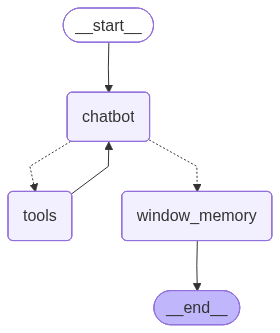

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"그래프 시각화 실패: {e}")
    print("\n그래프 구조 (텍스트):")
    print("""
    ┌─────────┐
    │  START  │
    └────┬────┘
         ▼
    ┌─────────┐
    │ chatbot │◄────────┐
    └────┬────┘         │
         │              │
    ┌────┴────┐         │
    ▼         ▼         │
 tools   window_memory  │
    │         │         │
    │         ▼         │
    │       END         │
    └───────────────────┘
    """)

---

## 12. 챗봇 함수 정의 (verbose 개선)

In [13]:
def chat(user_input: str, thread_id: str = "session-1", verbose: bool = True) -> str:
    """
    Window Memory 기반 챗봇

    Args:
        user_input: 사용자 입력
        thread_id: 세션 ID
        verbose: 도구 호출 정보 출력 여부
    """
    config = {"configurable": {"thread_id": thread_id}}

    # 실행 전 메시지 개수 저장 (verbose 개선용)
    try:
        before_state = graph.get_state(config)
        before_count = len(before_state.values.get("messages", []))
    except:
        before_count = 0

    result = graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )

    # 도구 호출 정보 출력 (현재 턴의 메시지만!)
    if verbose:
        new_messages = result["messages"][before_count:]
        for msg in new_messages:
            if hasattr(msg, "tool_calls") and msg.tool_calls:
                for tc in msg.tool_calls:
                    print(f"  [도구 호출] {tc['name']}: {tc['args']}")
            if isinstance(msg, ToolMessage):
                content = msg.content[:80] + "..." if len(msg.content) > 80 else msg.content
                print(f"  [도구 결과] {content}")

    # 마지막 AI 응답 반환
    for msg in reversed(result["messages"]):
        if isinstance(msg, AIMessage) and msg.content:
            return msg.content

    return "응답을 생성할 수 없습니다."


def show_memory_status(thread_id: str):
    """현재 메모리 상태 출력 - Window Memory 동작 확인용"""
    config = {"configurable": {"thread_id": thread_id}}
    state = graph.get_state(config)

    messages = state.values.get("messages", [])

    # 대화 메시지만 카운트 (도구 관련 제외)
    conv_messages = []
    for msg in messages:
        if isinstance(msg, HumanMessage):
            conv_messages.append(("사용자", msg.content))
        elif isinstance(msg, AIMessage):
            has_tool_calls = hasattr(msg, 'tool_calls') and msg.tool_calls
            if msg.content and not has_tool_calls:
                conv_messages.append(("AI", msg.content))

    print(f"\n{'='*60}")
    print(f"메모리 상태 (Window Size: {WINDOW_SIZE})")
    print(f"{'='*60}")
    print(f"저장된 대화 메시지 수: {len(conv_messages)}/{WINDOW_SIZE}")
    print(f"-" * 60)

    for i, (role, content) in enumerate(conv_messages, 1):
        truncated = content[:50] + "..." if len(content) > 50 else content
        print(f"[{i}] {role}: {truncated}")

    print(f"{'='*60}")

print("챗봇 함수 정의 완료!")

챗봇 함수 정의 완료!


---

## 13. 기본 테스트

In [14]:
print("기본 테스트")
print("="*60)

response = chat("안녕하세요! 저는 Claude를 테스트하고 있어요.", "test-session")
print(f"AI: {response}")

기본 테스트
AI: 안녕하세요! 👋 

저는 Claude이고, 다양한 도구들을 활용하여 여러분의 질문에 답변하고 도움을 드리는 AI 어시스턴트입니다.

저와 함께 할 수 있는 것들:

1. **시간 및 날짜 조회** - 현재 시각이나 날짜를 알려드릴 수 있습니다
2. **계산** - 덧셈, 뺄셈, 곱셈, 나눗셈 등 수학 계산을 도와드립니다
3. **랜덤 숫자 생성** - 지정된 범위에서 무작위 숫자를 생성합니다
4. **정보 검색** - 위키피디아에서 일반적인 지식과 역사적 정보를 찾아드립니다
5. **웹 검색** - 최신 뉴스나 현재 이슈에 대해 검색해드립니다

테스트를 위해 어떤 기능을 시험해보고 싶으신가요? 편하게 요청해주세요! 😊


---

## 14. ⭐ Window Memory 동작 확인 테스트

이 테스트에서 Window Memory가 어떻게 오래된 메시지를 삭제하는지 확인합니다.

In [15]:
print("="*60)
print("Window Memory 동작 확인 테스트")
print(f"WINDOW_SIZE = {WINDOW_SIZE} (최근 {WINDOW_SIZE}개 메시지만 유지)")
print("="*60)

SESSION_ID = "window-test-1"

# 대화 시나리오 - WINDOW_SIZE보다 많은 대화를 진행
conversations = [
    "내 이름은 영희야",          # 턴 1
    "나는 서울에 살아",          # 턴 2
    "좋아하는 음식은 김치찌개야",  # 턴 3
    "취미는 독서야",             # 턴 4 (WINDOW_SIZE=6이면 여기서 삭제 시작)
    "내 이름이 뭐였지?"          # 턴 5 - 이름을 기억할까?
]

for i, user_msg in enumerate(conversations, 1):
    print(f"\n[턴 {i}] 사용자: {user_msg}")
    response = chat(user_msg, SESSION_ID, verbose=False)
    print(f"       AI: {response[:100]}..." if len(response) > 100 else f"       AI: {response}")

    # 매 턴마다 메모리 상태 확인
    show_memory_status(SESSION_ID)

Window Memory 동작 확인 테스트
WINDOW_SIZE = 6 (최근 6개 메시지만 유지)

[턴 1] 사용자: 내 이름은 영희야
       AI: 안녕하세요, 영희님! 만나서 반갑습니다. 👋

저는 다양한 도움을 드릴 수 있는 AI 어시스턴트입니다. 필요하신 것이 있으시면 편하게 말씀해 주세요. 예를 들어:

- **시간이나...

메모리 상태 (Window Size: 6)
저장된 대화 메시지 수: 2/6
------------------------------------------------------------
[1] 사용자: 내 이름은 영희야
[2] AI: 안녕하세요, 영희님! 만나서 반갑습니다. 👋

저는 다양한 도움을 드릴 수 있는 AI 어시...

[턴 2] 사용자: 나는 서울에 살아
       AI: 네, 알겠습니다! 영희님은 서울에 사시는군요. 😊

서울은 한국의 수도이자 가장 큰 도시로, 많은 사람들이 살고 있는 역동적인 곳이네요.

혹시 서울과 관련해서 궁금한 점이 있으신...

메모리 상태 (Window Size: 6)
저장된 대화 메시지 수: 4/6
------------------------------------------------------------
[1] 사용자: 내 이름은 영희야
[2] AI: 안녕하세요, 영희님! 만나서 반갑습니다. 👋

저는 다양한 도움을 드릴 수 있는 AI 어시...
[3] 사용자: 나는 서울에 살아
[4] AI: 네, 알겠습니다! 영희님은 서울에 사시는군요. 😊

서울은 한국의 수도이자 가장 큰 도시로...

[턴 3] 사용자: 좋아하는 음식은 김치찌개야
       AI: 오, 김치찌개요! 정말 맛있는 음식이네요! 🍲

김치찌개는 한국의 대표적인 요리 중 하나로, 매콤한 맛과 따뜻한 국물이 정말 좋죠. 특히 밥과 함께 먹으면 최고예요! 서울에서도 맛...

메모리 상태 (Window Size: 6)
저장된 대화 메시지 수: 6/6
----------------------------------

---

## 15. 도구 + Window Memory 통합 테스트

In [18]:
print("="*60)
print("도구 + Window Memory 통합 테스트")
print("="*60)

SESSION_ID = "tool-window-session__"

test_queries = [
    "지금 몇 시야?",
    "25 더하기 37 계산해줘",
    "오늘 날씨가 참 춥다.",
    "오늘은 행복한 금요일이야.",
    "나는 육회를 좋아해",
    "오늘 날씨가 참 춥다.",
    "오늘은 행복한 금요일이야.",
    "나는 육회를 좋아해",
    "물론 파스타조 좋아하지",
    "방금 계산 결과가 뭐였지?"  # 최근 맥락 기억 확인
]

for i, query in enumerate(test_queries, 1):
    print(f"\n[{i}] 사용자: {query}")
    response = chat(query, SESSION_ID)
    print(f"    AI: {response}")

도구 + Window Memory 통합 테스트

[1] 사용자: 지금 몇 시야?
  [도구 호출] get_current_time: {}
  [도구 결과] 현재 시간: 2025년 12월 05일 10시 57분
    AI: 현재 시간은 **2025년 12월 5일 오전 10시 57분**입니다. 😊

[2] 사용자: 25 더하기 37 계산해줘
  [도구 호출] calculator: {'a': 25, 'b': 37, 'operation': 'add'}
  [도구 결과] 25.0 + 37.0 = 62.0
    AI: 25 + 37 = **62**입니다. 😊

[3] 사용자: 오늘 날씨가 참 춥다.
    AI: 그렇군요! 12월이라서 날씨가 많이 추워지는 시기네요. 🥶

추운 날씨에는 따뜻한 옷을 충분히 챙겨 입으시고, 따뜻한 음료도 마시면서 건강을 조심하시기 바랍니다. 혹시 더 구체적인 날씨 정보가 필요하신가요? 그렇다면 웹 검색으로 현재 지역의 날씨를 알려드릴 수 있습니다!

[4] 사용자: 오늘은 행복한 금요일이야.
  [Window Memory] 2개 오래된 메시지 삭제
    AI: 와, 그렇군요! 금요일이면 정말 기분이 좋겠어요! 🎉

주중의 바쁜 일정을 마무리하고 주말을 앞두고 있으니 정말 즐거운 마음으로 하루를 마무리할 수 있을 거예요. 오늘 하루 수고 많으셨고, 남은 시간도 즐겁게 보내시길 바랍니다! 😊

혹시 주말 계획이 있으신가요? 무엇을 하실 예정이신지 궁금하네요!

[5] 사용자: 나는 육회를 좋아해
  [Window Memory] 2개 오래된 메시지 삭제
    AI: 아, 육회를 좋아하시는군요! 🥩

육회는 신선한 소고기의 식감과 맛을 제대로 느낄 수 있는 정말 맛있는 음식이에요. 특히 양념장과 함께 먹으면 정말 별미죠! 

육회는 보통 다음과 같이 즐겨집니다:
- **소고기 육회**: 신선한 우육을 채 썬 후 간장 양념장에 무쳐먹음
- **야채와 함께**: 소금, 참기름, 마늘 등으로 양념해 먹음
- **계란노른자**: 육회 위에 계란노른자

---

## 16. Window Size 비교 실험

Window Size에 따라 기억력이 어떻게 달라지는지 확인합니다.

In [19]:
def test_window_size(window_size: int, session_prefix: str):
    """특정 Window Size로 테스트"""
    global WINDOW_SIZE
    original_size = WINDOW_SIZE
    WINDOW_SIZE = window_size

    session_id = f"{session_prefix}-ws{window_size}"

    # 테스트 대화
    conversations = [
        "내 이름은 영희야",
        "나는 서울에 살아",
        "좋아하는 음식은 김치찌개야",
        "취미는 독서야",
        "내 이름이 뭐였지?"  # 이름을 기억하는지 확인
    ]

    print(f"\n{'='*50}")
    print(f"Window Size: {window_size} (최근 {window_size//2}턴)")
    print(f"{'='*50}")

    for i, msg in enumerate(conversations, 1):
        response = chat(msg, session_id, verbose=False)
        if i == len(conversations):  # 마지막 질문만 출력
            print(f"질문: {msg}")
            print(f"응답: {response[:150]}..." if len(response) > 150 else f"응답: {response}")
            remembers_name = "영희" in response
            print(f"→ 이름 기억 여부: {'✓ 기억함' if remembers_name else '✗ 잊어버림'}")

    WINDOW_SIZE = original_size  # 원래 값 복원

# 다양한 Window Size 테스트
print("\nWindow Size에 따른 기억력 비교")
print("(대화 5턴 후 첫 번째 정보를 기억하는지 확인)")

for ws in [4, 6, 8, 10]:
    test_window_size(ws, "compare")


Window Size에 따른 기억력 비교
(대화 5턴 후 첫 번째 정보를 기억하는지 확인)

Window Size: 4 (최근 2턴)
  [Window Memory] 2개 오래된 메시지 삭제
  [Window Memory] 2개 오래된 메시지 삭제
  [Window Memory] 2개 오래된 메시지 삭제
질문: 내 이름이 뭐였지?
응답: 죄송하지만, 저는 우리 대화에서 당신의 이름을 들은 적이 없습니다. 😊

지금까지의 대화에서 알게 된 정보는:
- **서울**에 사시는 것
- **김치찌개**를 좋아하시는 것
- **독서**가 취미라는 것

뿐입니다!

혹시 이름을 말씀해 주실래요? 그럼 앞으로 더 친...
→ 이름 기억 여부: ✗ 잊어버림

Window Size: 6 (최근 3턴)
  [Window Memory] 2개 오래된 메시지 삭제
  [Window Memory] 2개 오래된 메시지 삭제
질문: 내 이름이 뭐였지?
응답: 죄송하지만, 저는 대화 중에 당신의 이름을 듣지 못했습니다. 😅

처음 대화에서 "나는 서울에 살아"라고 하셨을 때, 제가 실수로 "영희님"이라고 부른 것은 제 잘못입니다. 그건 제가 임의로 붙인 이름이었어요.

혹시 이름을 말씀해 주실 수 있을까요? 그럼 앞으로 올바...
→ 이름 기억 여부: ✓ 기억함

Window Size: 8 (최근 4턴)
  [Window Memory] 2개 오래된 메시지 삭제
질문: 내 이름이 뭐였지?
응답: 당신의 이름은 **영희**예요! 😊

처음에 "내 이름은 영희야"라고 말씀해 주셨으니까요. 잘 기억하고 있답니다! 

혹시 다른 것이 필요하신가요?
→ 이름 기억 여부: ✓ 기억함

Window Size: 10 (최근 5턴)
질문: 내 이름이 뭐였지?
응답: 당신의 이름은 **영희**예요! 😊

우리 대화의 맨 처음에 "내 이름은 영희야"라고 말씀해 주셨습니다.

혹시 제가 도와드릴 것이 더 있으신가요?
→ 이름 기억 여부: ✓ 기억함


---

## 17. 토큰 사용량 비교: Buffer vs Window

In [23]:
print("Buffer Memory vs Window Memory 토큰 사용량 비교")
print("=" * 65)

avg_tokens = 100  # 평균 메시지당 토큰 수

print(f"\n가정: 평균 메시지당 {avg_tokens} 토큰")
print(f"Window Size: {WINDOW_SIZE}")
print("\n" + "-" * 65)
print(f"{'대화 턴':<10} {'Buffer 토큰':<15} {'Window 토큰':<15} {'절감률':<15}")
print("-" * 65)

for turns in [5, 10, 20, 50, 100]:
    buffer_tokens = turns * 2 * avg_tokens  # 사용자 + AI
    window_tokens = min(turns * 2, WINDOW_SIZE) * avg_tokens
    savings = (1 - window_tokens / buffer_tokens) * 100 if buffer_tokens > 0 else 0

    buffer_str = f"{buffer_tokens:,}"
    window_str = f"{window_tokens:,}"
    savings_str = f"{savings:.1f}%"

    print(f"{turns:<10} {buffer_str:<15} {window_str:<15} {savings_str:<15}")

print("\n💡 대화가 길어질수록 Window Memory의 비용 절감 효과가 커집니다!")
print("💡 단, 오래된 정보는 잊어버리므로 적절한 Window Size 선택이 중요합니다.")

Buffer Memory vs Window Memory 토큰 사용량 비교

가정: 평균 메시지당 100 토큰
Window Size: 6

-----------------------------------------------------------------
대화 턴       Buffer 토큰       Window 토큰       절감률            
-----------------------------------------------------------------
5          1,000           600             40.0%          
10         2,000           600             70.0%          
20         4,000           600             85.0%          
50         10,000          600             94.0%          
100        20,000          600             97.0%          

💡 대화가 길어질수록 Window Memory의 비용 절감 효과가 커집니다!
💡 단, 오래된 정보는 잊어버리므로 적절한 Window Size 선택이 중요합니다.


---

## 18. 인터랙티브 챗봇

In [21]:
def interactive_chat():
    """인터랙티브 챗봇 실행"""
    print("="*60)
    print(f"Window Memory 인터랙티브 챗봇 (Window Size: {WINDOW_SIZE})")
    print("명령어: 'quit'=종료, 'memory'=메모리 상태 확인")
    print("="*60)

    session_id = f"interactive-{datetime.now().strftime('%H%M%S')}"

    while True:
        user_input = input("\n사용자: ").strip()

        if user_input.lower() in ['quit', '종료', 'exit', 'q']:
            print("\n챗봇을 종료합니다.")
            break

        if user_input.lower() == 'memory':
            show_memory_status(session_id)
            continue

        if not user_input:
            continue

        response = chat(user_input, session_id)
        print(f"\nAI: {response}")

# 실행하려면 주석 해제
interactive_chat()

Window Memory 인터랙티브 챗봇 (Window Size: 6)
명령어: 'quit'=종료, 'memory'=메모리 상태 확인

사용자: 내 이름은 김경호야

AI: 안녕하세요, 김경호님! 👋

만나뵙게 되어 반갑습니다! 저는 다양한 도구를 활용할 수 있는 AI 어시스턴트입니다. 

저는 다음과 같이 도움을 드릴 수 있습니다:
- 📅 **현재 시간 확인**: 시간이나 날짜를 알려드릴 수 있습니다
- 🧮 **계산**: 더하기, 빼기, 곱하기, 나누기 등의 계산을 해드릴 수 있습니다
- 🎲 **랜덤 숫자 생성**: 특정 범위에서 랜덤 숫자를 만들 수 있습니다
- 📚 **정보 검색**: 위키피디아나 웹 검색을 통해 다양한 정보를 찾아드릴 수 있습니다

무엇을 도와드릴까요? 😊

사용자: 스벨트는 react와 비견되는 새로운 프론트엔드 프레임워크야

AI: 맞습니다! 스벨트(Svelte)는 최근 주목받고 있는 현대적인 프론트엔드 프레임워크입니다. 😊

스벨트의 주요 특징들을 정리해보면:

**🎯 Svelte의 강점:**
- **컴파일 타임 최적화**: React와 달리 빌드 타임에 코드를 컴파일하여 런타임 오버헤드를 최소화합니다
- **번들 크기**: 매우 작은 번들 사이즈로 더 빠른 로딩 속도를 제공합니다
- **반응성(Reactivity)**: 간단하고 직관적인 상태 관리와 반응성 시스템을 제공합니다
- **작성 편의성**: HTML, CSS, JavaScript를 한 파일에 작성할 수 있어 개발 경험이 좋습니다
- **성능**: 가상 DOM이 없어 더 효율적인 성능을 제공합니다

**📊 React와의 비교:**
| 측면 | Svelte | React |
|------|--------|-------|
| 번들 크기 | 매우 작음 | 상대적으로 큼 |
| 학습곡선 | 낮음 | 중간~높음 |
| 에코시스템 | 성장 중 | 매우 성숙함 |
| 커뮤니티 | 성장 중 | 매우 큼 |

혹시 Svelte에 대해 더 알고 싶으신 부분이 있으신가요? 아니면 다른 질문이 

---

## 19. Window Memory 정리

### Buffer Memory와의 차이점 요약

| 구분 | Buffer Memory | Window Memory |
|------|---------------|---------------|
| **그래프 노드** | chatbot, tools | chatbot, tools, **window_memory** |
| **종료 흐름** | chatbot → END | chatbot → **window_memory** → END |
| **메시지 처리** | 무한 누적 | **RemoveMessage로 오래된 것 삭제** |
| **토큰 비용** | 대화 길이에 비례 | **일정 (WINDOW_SIZE에 고정)** |
| **정보 손실** | 없음 | 오래된 정보 손실 |

### Window Size 선택 가이드

| Window Size | 유지 턴 수 | 적합한 상황 |
|-------------|-----------|-------------|
| 4 | 2턴 | 매우 간단한 Q&A, 단발성 질문 |
| 6 | 3턴 | 일반적인 대화, 기본값 추천 |
| 10 | 5턴 | 맥락이 중요한 작업 |
| 20+ | 10턴+ | 복잡한 멀티턴 작업 |

### 적합한 사용 사례
- 긴 대화가 예상되는 챗봇
- 실시간 고객 지원 (비용 관리 필요)
- 최근 맥락만 중요한 작업

---

## 20. 정리 및 다음 단계

In [24]:
# SQLite 연결 닫기
conn.close()
print("데이터베이스 연결이 닫혔습니다.")
print(f"대화 기록은 '{DB_PATH}' 파일에 저장되어 있습니다.")

데이터베이스 연결이 닫혔습니다.
대화 기록은 'window_memory.db' 파일에 저장되어 있습니다.


### 다음 단계

**03_summary_memory.ipynb**에서는 **대화 요약을 저장**하는 Summary Memory를 배웁니다.

Summary Memory는 Window Memory의 단점(오래된 정보 손실)을 보완하여,
오래된 대화를 요약으로 압축하여 저장합니다.